In [ ]:
!pip install wandb einops pytorch-lightning

In [ ]:
import wandb
import torch
import einops
from torch import nn
from PIL import Image
import pytorch_lightning as pl
from functools import lru_cache
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision import transforms, datasets

In [ ]:
wandb.login()

In [2]:
pl.seed_everything(42)
project = 'vit'
max_epochs = 5
batch_size = 64
in_channels = 3
img_size = 32
patch_size = 4 # large img_size and small patch_size gives a better model and finer attention maps but requires a lot of computing power
num_classes = 10
dim = 64
depth = 6
heads = 8
hidden_dim = 128
lr = 3e-4

Global seed set to 42


In [3]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, img_size, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.T = transforms.Compose(
                    [
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ]
                )
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage in ('fit', 'validate'):
            self.train_data = datasets.CIFAR10(self.data_dir, train=True, transform=self.T)
            self.val_data = datasets.CIFAR10(self.data_dir, train=False, transform=self.T)

    @lru_cache(maxsize=128)
    def get_dataloader(self, data, split):
        if split == 'train':
            shuffle = True
        else:
            shuffle = False
        return DataLoader(data, batch_size=self.batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

    def train_dataloader(self):
        return self.get_dataloader(self.train_data, 'train')

    def val_dataloader(self):
        return self.get_dataloader(self.val_data, 'val')

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.fc1 = nn.Linear(dim, dim*3)
        self.fc2 = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        qkv = self.fc1(x)
        q, k, v = einops.rearrange(qkv, "b n (qkv h d) -> qkv b h n d", qkv=3, h=self.heads)
        attn = torch.einsum("bhid,bhjd->bhij", q, k) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = torch.einsum("bhij,bhjd->bhid", attn, v)
        out = einops.rearrange(out, "b h n d -> b n (h d)")
        out = self.dropout(self.fc2(out))
        return out, attn

In [5]:
class Block(nn.Module):
    def __init__(self, dim, heads, hidden_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.mhsa = MultiHeadSelfAttention(dim, heads)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        attn_out, attn = self.mhsa(self.ln1(x))
        x = attn_out + x
        x = self.mlp(self.ln2(x)) + x
        return x, attn

In [6]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, heads, hidden_dim):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, heads, hidden_dim) for _ in range(depth)])
            
    def forward(self, x):
        attns = []
        for block in self.blocks:
            x, attn = block(x)
            attns.append(attn)
        return x, torch.stack(attns, dim=1)

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, in_channels, img_size, patch_size, num_classes, dim, depth, heads, hidden_dim):
        super().__init__()
        assert img_size % patch_size == 0, 'img_size must be divisible by patch_size!!'

        num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(in_channels, dim, patch_size, stride=patch_size)
        self.cls_tokens = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.empty(1, (num_patches + 1), dim))
        self.dropout = nn.Dropout(0.1)

        self.transformer = Transformer(depth, dim, heads, hidden_dim)
        self.ln = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, num_classes)
        self.init_parameters()

    def init_parameters(self):
        nn.init.normal_(self.pos_embedding, std=0.02)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.normal_(self.fc.bias, std=1e-6)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = einops.rearrange(x, 'b c h w -> b (h w) c')

        cls_tokens = self.cls_tokens.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        x, attn = self.transformer(x)
        x = self.ln(x[:, 0])
        x = self.fc(x)
        return x, attn

In [8]:
class Model(pl.LightningModule):
    def __init__(self, in_channels, image_size, patch_size, num_classes, dim, depth, heads, hidden_dim, lr):
        super().__init__()
        self.vit = VisionTransformer(in_channels, image_size, patch_size, num_classes, dim, depth, heads, hidden_dim)
        self.lr = lr
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.vit(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
        
    def shared_step(self, batch, split):
        x, y = batch
        preds, _ = self(x)
        loss = self.loss_fn(preds, y)
        acc = accuracy(preds, y)
        self.log(f'{split}_loss', loss, on_epoch=True, prog_bar=True)
        self.log(f'{split}_acc', acc, on_epoch=True, prog_bar=True)
        if split == 'train':
            return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        self.shared_step(batch, 'val')

In [9]:
cifar10_dm = CIFAR10DataModule('data/', img_size, batch_size)
model = Model(in_channels, img_size, patch_size, num_classes, dim, depth, heads, hidden_dim, lr)

In [10]:
wandb_logger = pl.loggers.WandbLogger(project=project)
trainer = pl.Trainer(max_epochs=max_epochs, gpus=1, precision=16, logger=wandb_logger, log_every_n_steps=10, deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [11]:
trainer.fit(model, datamodule=cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: zer0sh0t (use `wandb login --relogin` to force relogin)



  | Name    | Type              | Params
----------------------------------------------
0 | vit     | VisionTransformer | 208 K 
1 | loss_fn | CrossEntropyLoss  | 0     
----------------------------------------------
208 K     Trainable params
0         Non-trainable params
208 K     Total params
0.836     Total estimated model params size (MB)


Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


In [12]:
wandb.finish()

train_loss_step,1.32178
train_acc_step,0.5
epoch,4
trainer/global_step,3909
_runtime,1931
_timestamp,1626691199
_step,400
train_loss_epoch,1.16056
train_acc_epoch,0.57734
val_loss,1.15255
val_acc,0.5886


train_loss_step,█▇▇▇▅▄▆▅▆▆▅▅▃▄▃▃▄▂▅▄▂▃▄▁▁▂▃▄▂▂▃▁▂▂▃▂▂▂▁▂
train_acc_step,▁▂▂▁▃▆▂▃▃▄▅▄▅▅▆▅▅▇▅▄▇▇▅▇▇▇▅▄▇▆▇▇▆▇▆▆▅▅█▇
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▅▃▂▁
train_acc_epoch,▁▅▆▇█
val_loss,█▄▂▁▁
val_acc,▁▅▆▇█


In [28]:
@torch.no_grad()
def predict(img_path, model=model, transform=cifar10_dm.T, class_list=cifar10_dm.train_data.classes):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    img = img.to(model.device)
    pred, attn = model(img)
    pred = pred.argmax(dim=1)
    return class_list[pred.item()], attn

def plot_attn(attn, patch_size=patch_size, layer_idx=-1, heads=8, n_rows=4, n_cols=2):
    attn = attn[0, layer_idx]
    feat_size = int((attn.shape[1] - 1) ** 0.5) # ignoring the [CLS] token
    attn = attn[:, 0, 1:].view(heads, feat_size, feat_size) # ignoring the [CLS] token
    attn = F.interpolate(attn.unsqueeze(0), scale_factor=patch_size, mode="nearest").squeeze(0)
    attn = attn.cpu().numpy()

    fig = plt.figure(figsize=(40, 40))
    for i in range(heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax.imshow(attn[i], cmap='inferno')
    plt.show()
    plt.close()

dog torch.Size([1, 6, 8, 65, 65])


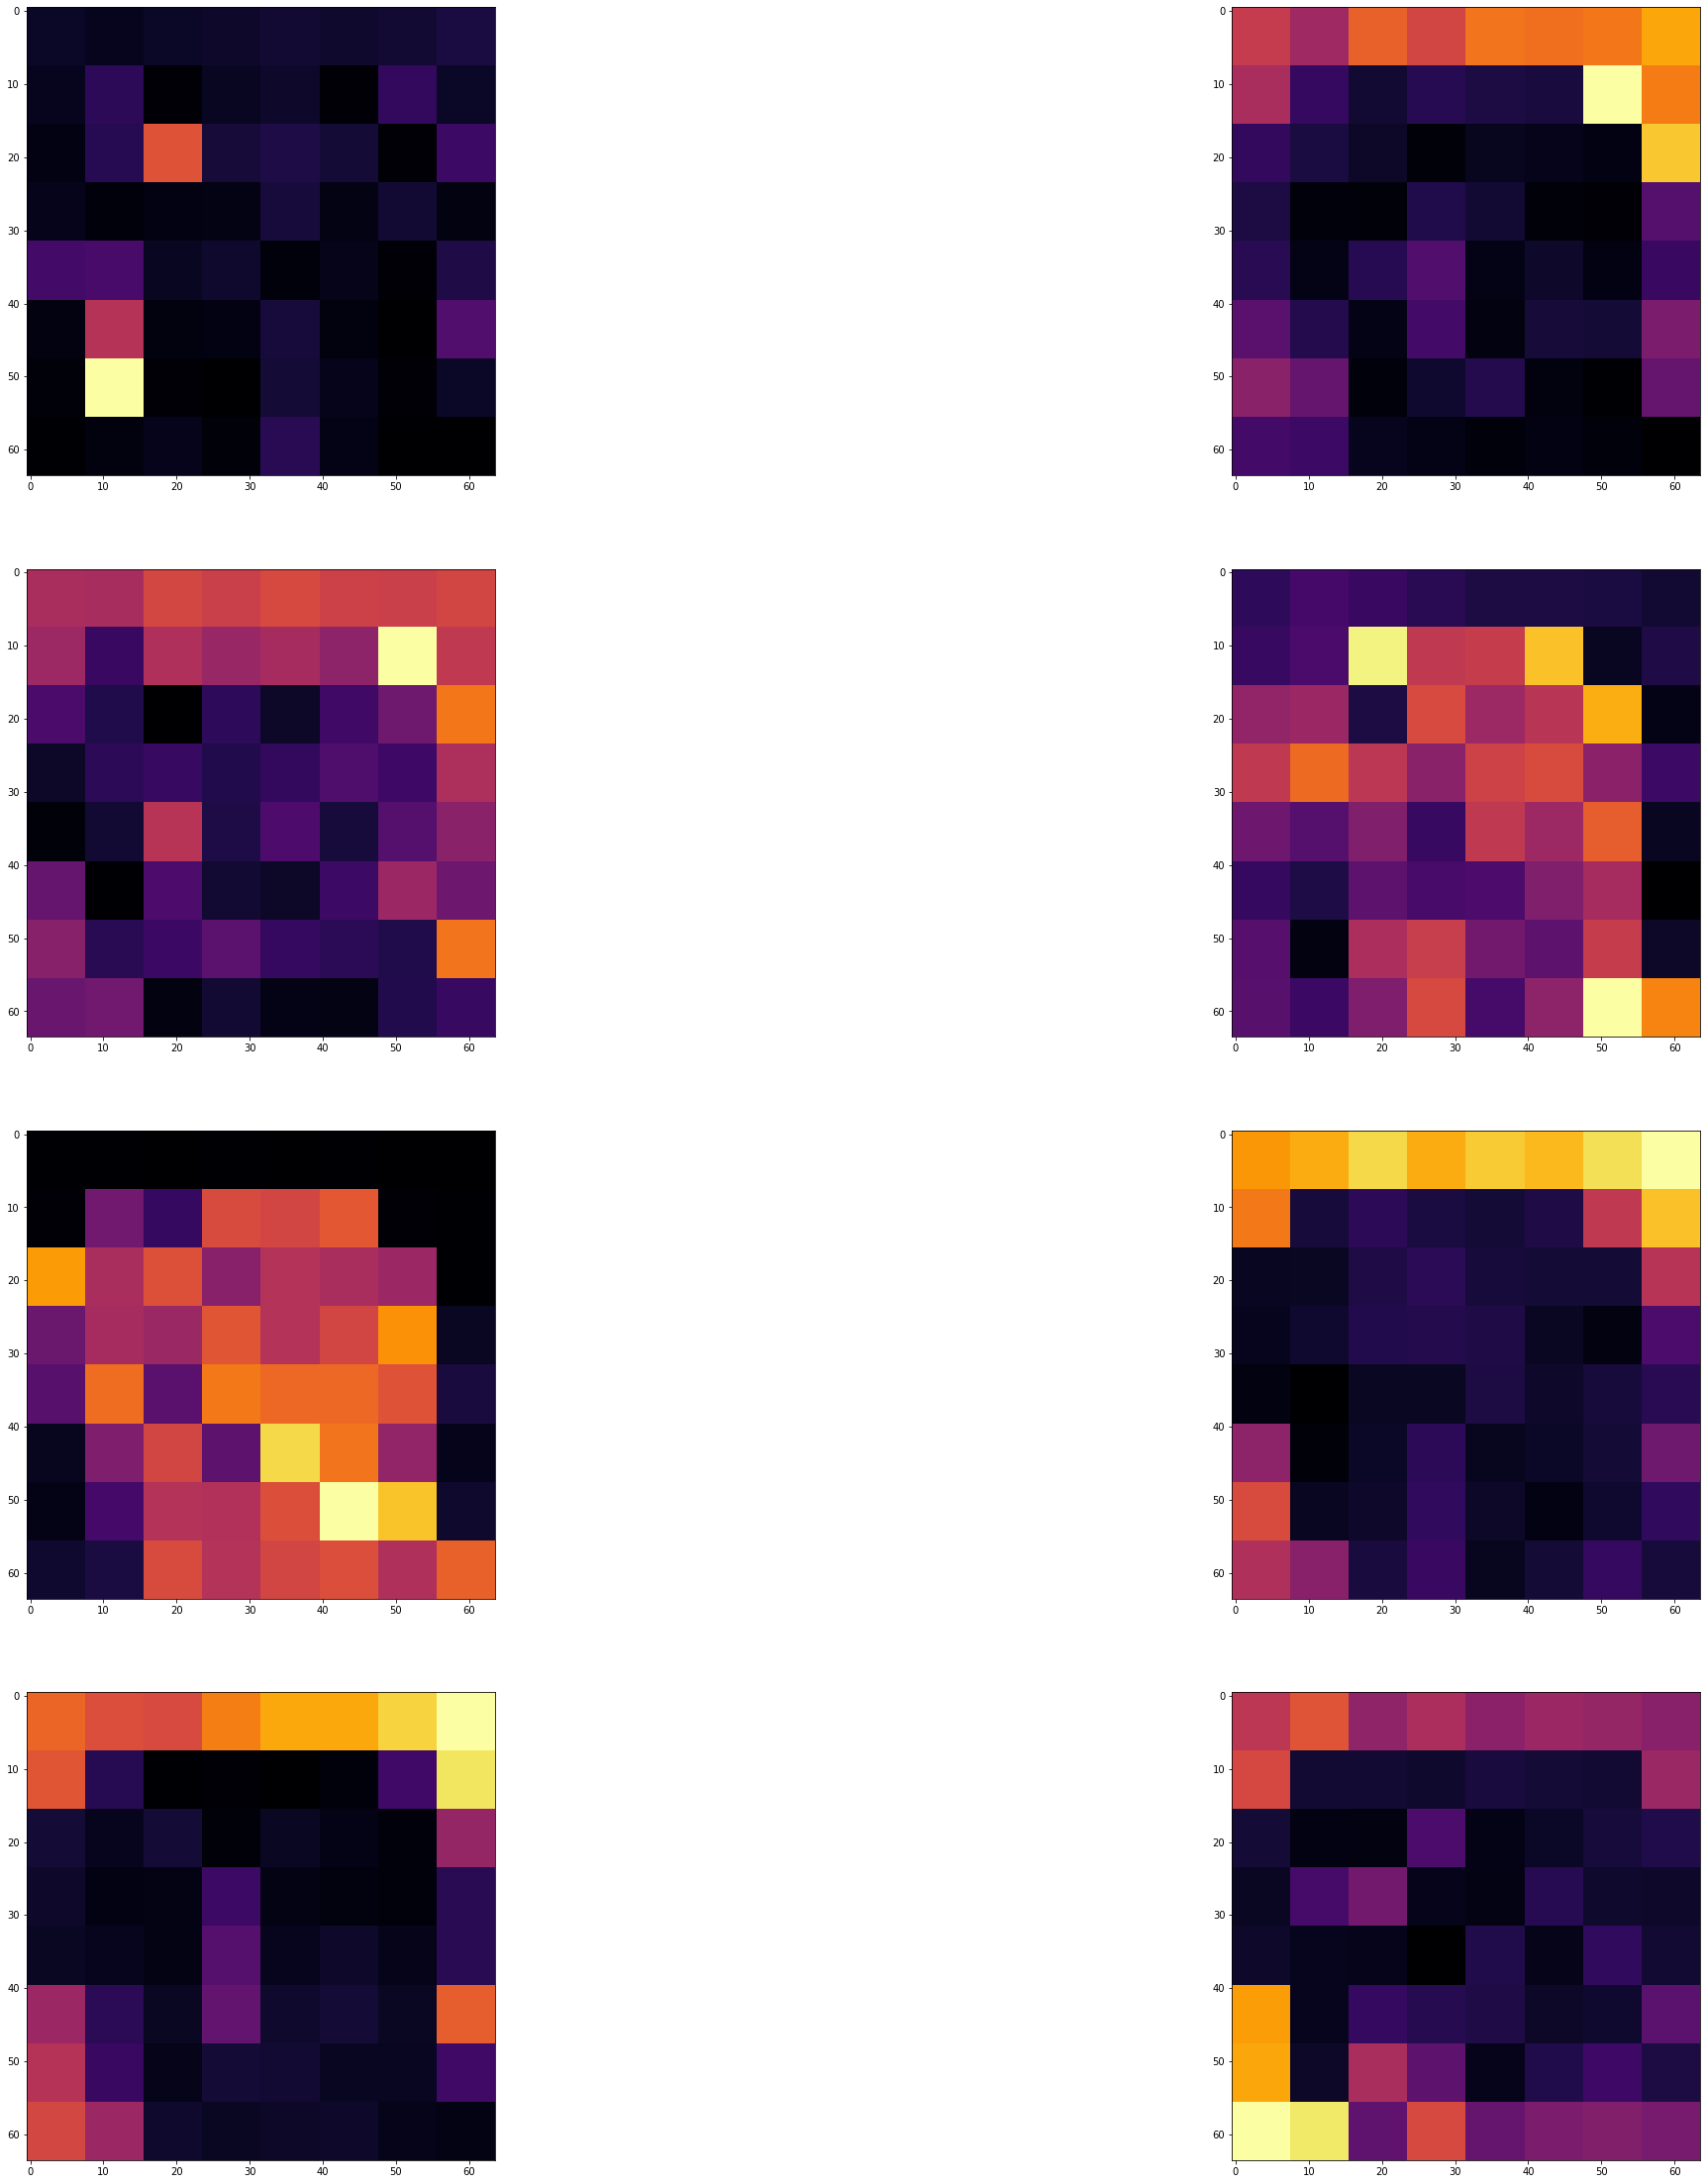

In [29]:
pred, attn = predict('dog.jpg')
print(pred, attn.shape)
plot_attn(attn)

horse torch.Size([1, 6, 8, 65, 65])


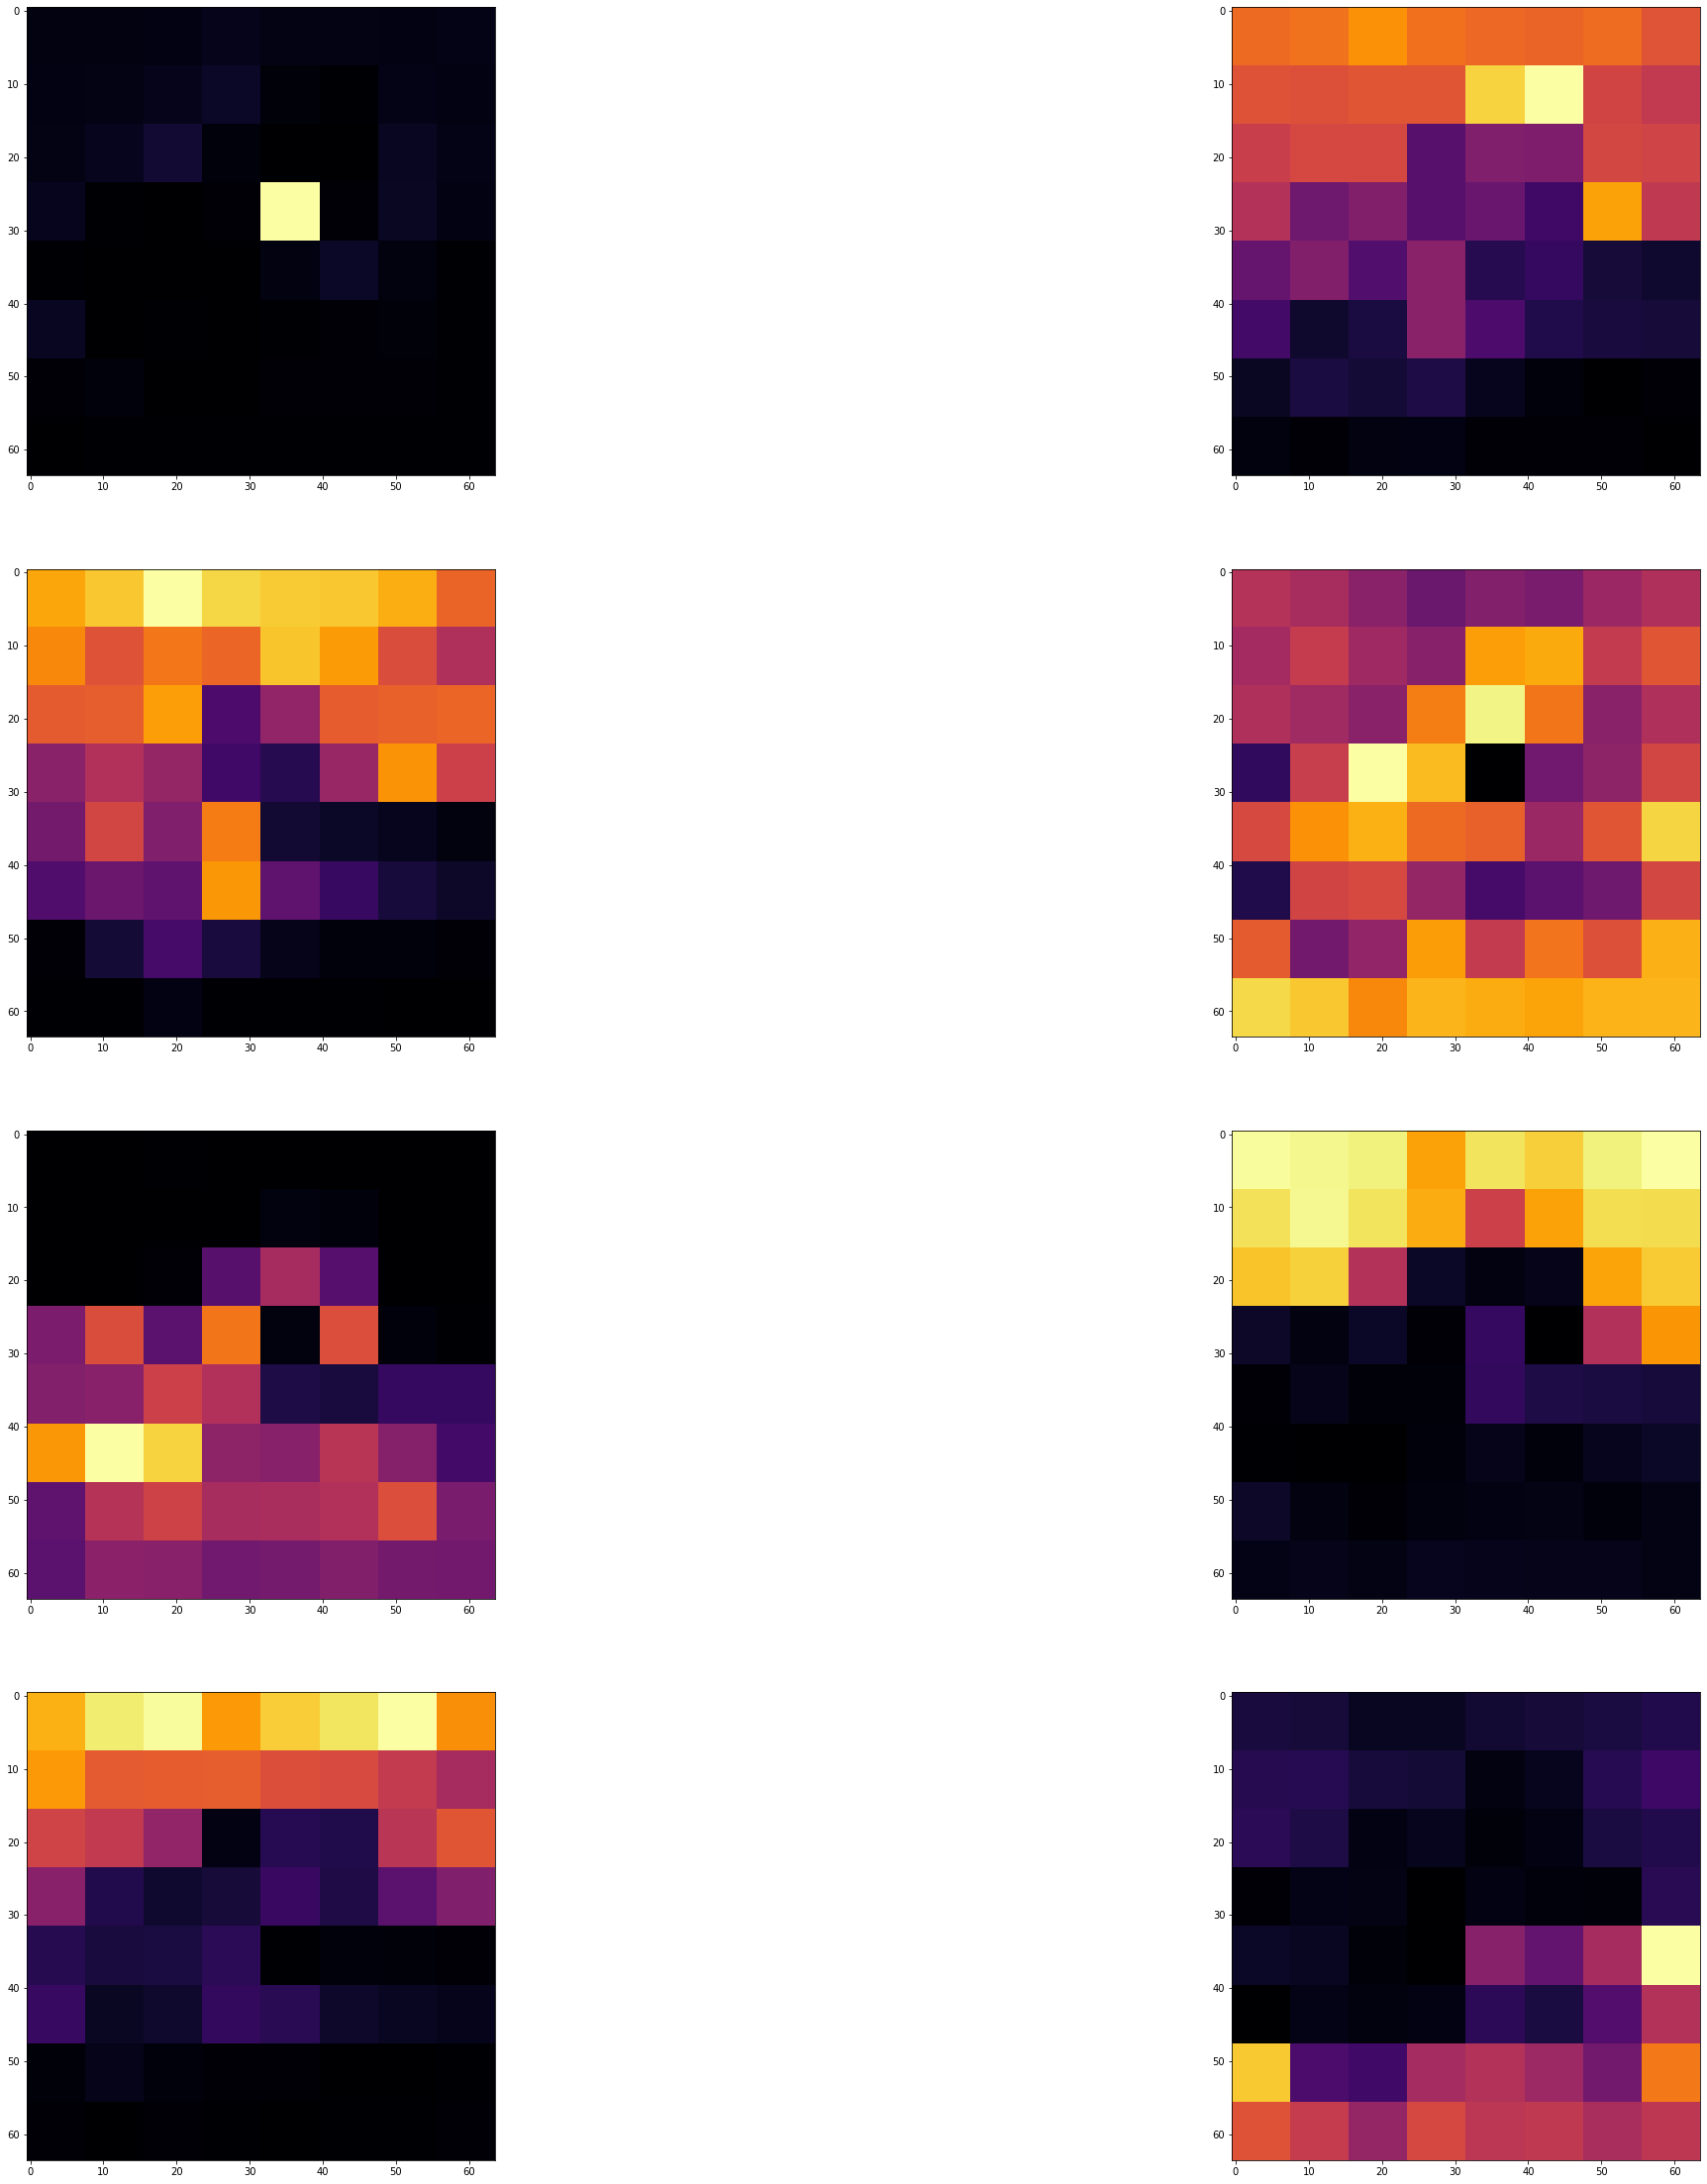

In [30]:
pred, attn = predict('horse.png')
print(pred, attn.shape)
plot_attn(attn)

bird torch.Size([1, 6, 8, 65, 65])


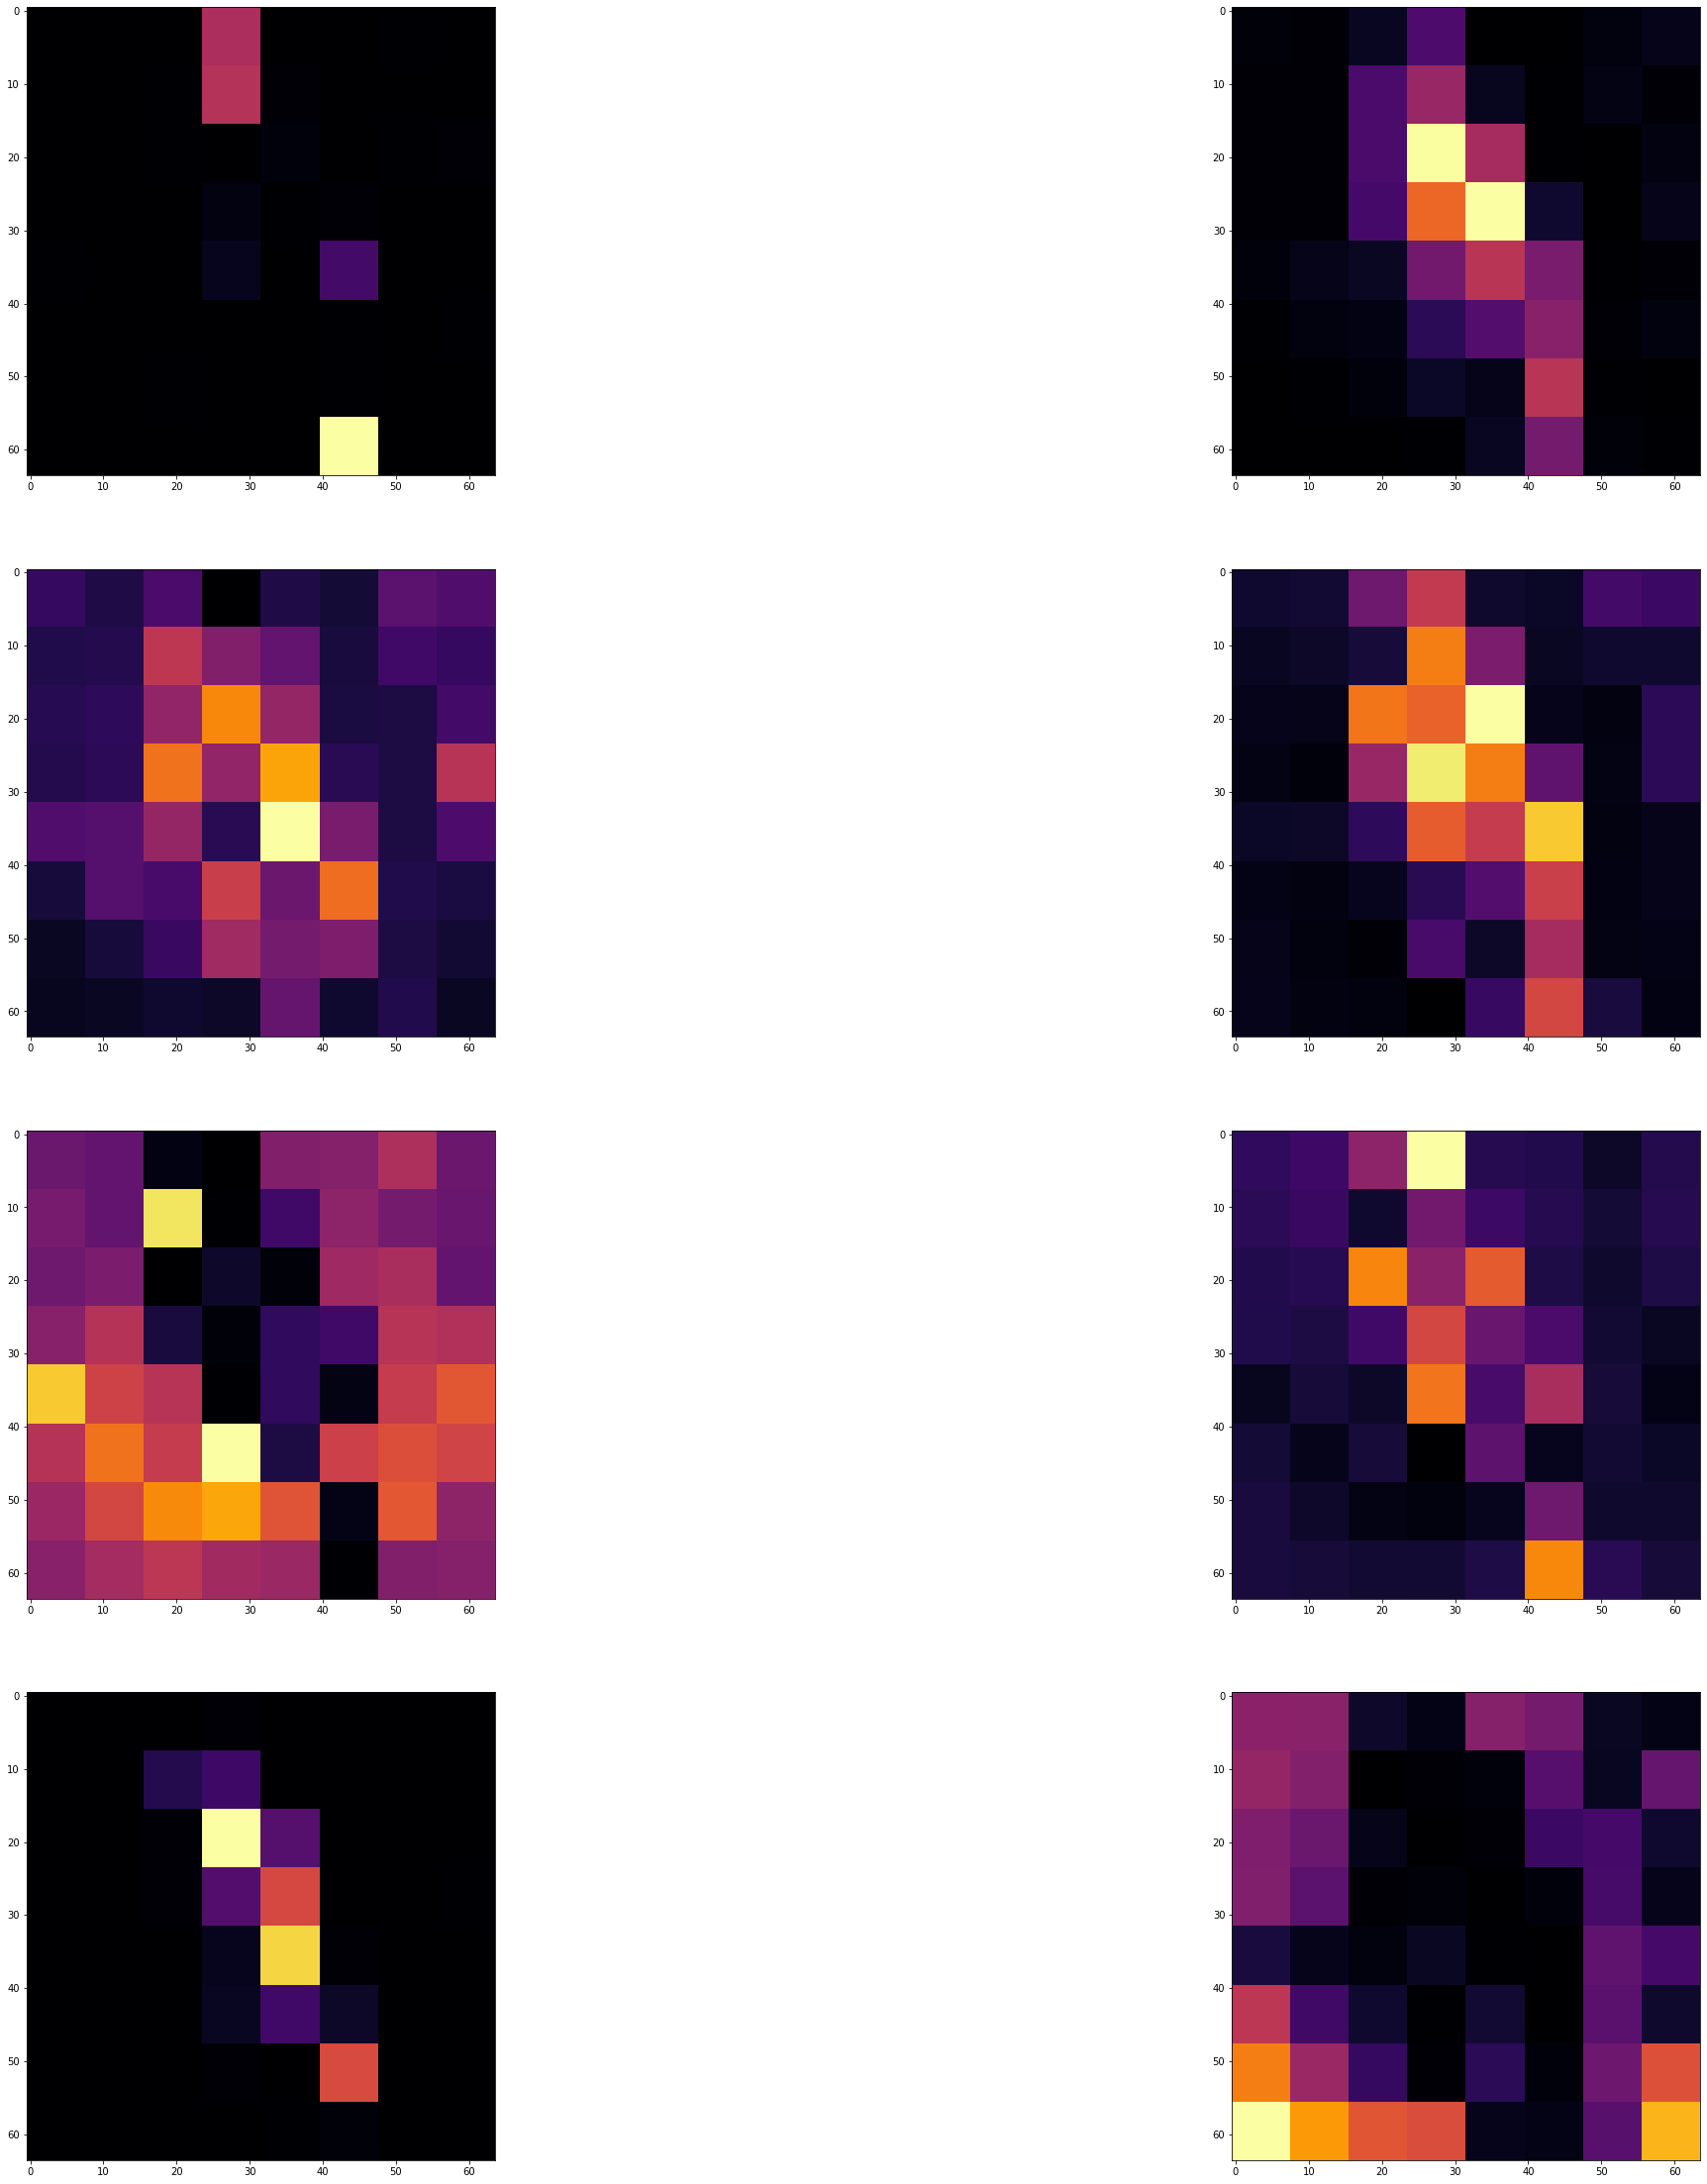

In [31]:
pred, attn = predict('bird.jpg')
print(pred, attn.shape)
plot_attn(attn)

In [24]:
# to get finer attention maps train the model with larger img_size and smaller patch_size
img_size = 224
patch_size = 8
transform = transforms.Compose(
    [
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)
new_model = Model(in_channels, img_size, patch_size, num_classes, dim, depth, heads, hidden_dim, lr)

frog torch.Size([1, 6, 8, 785, 785])


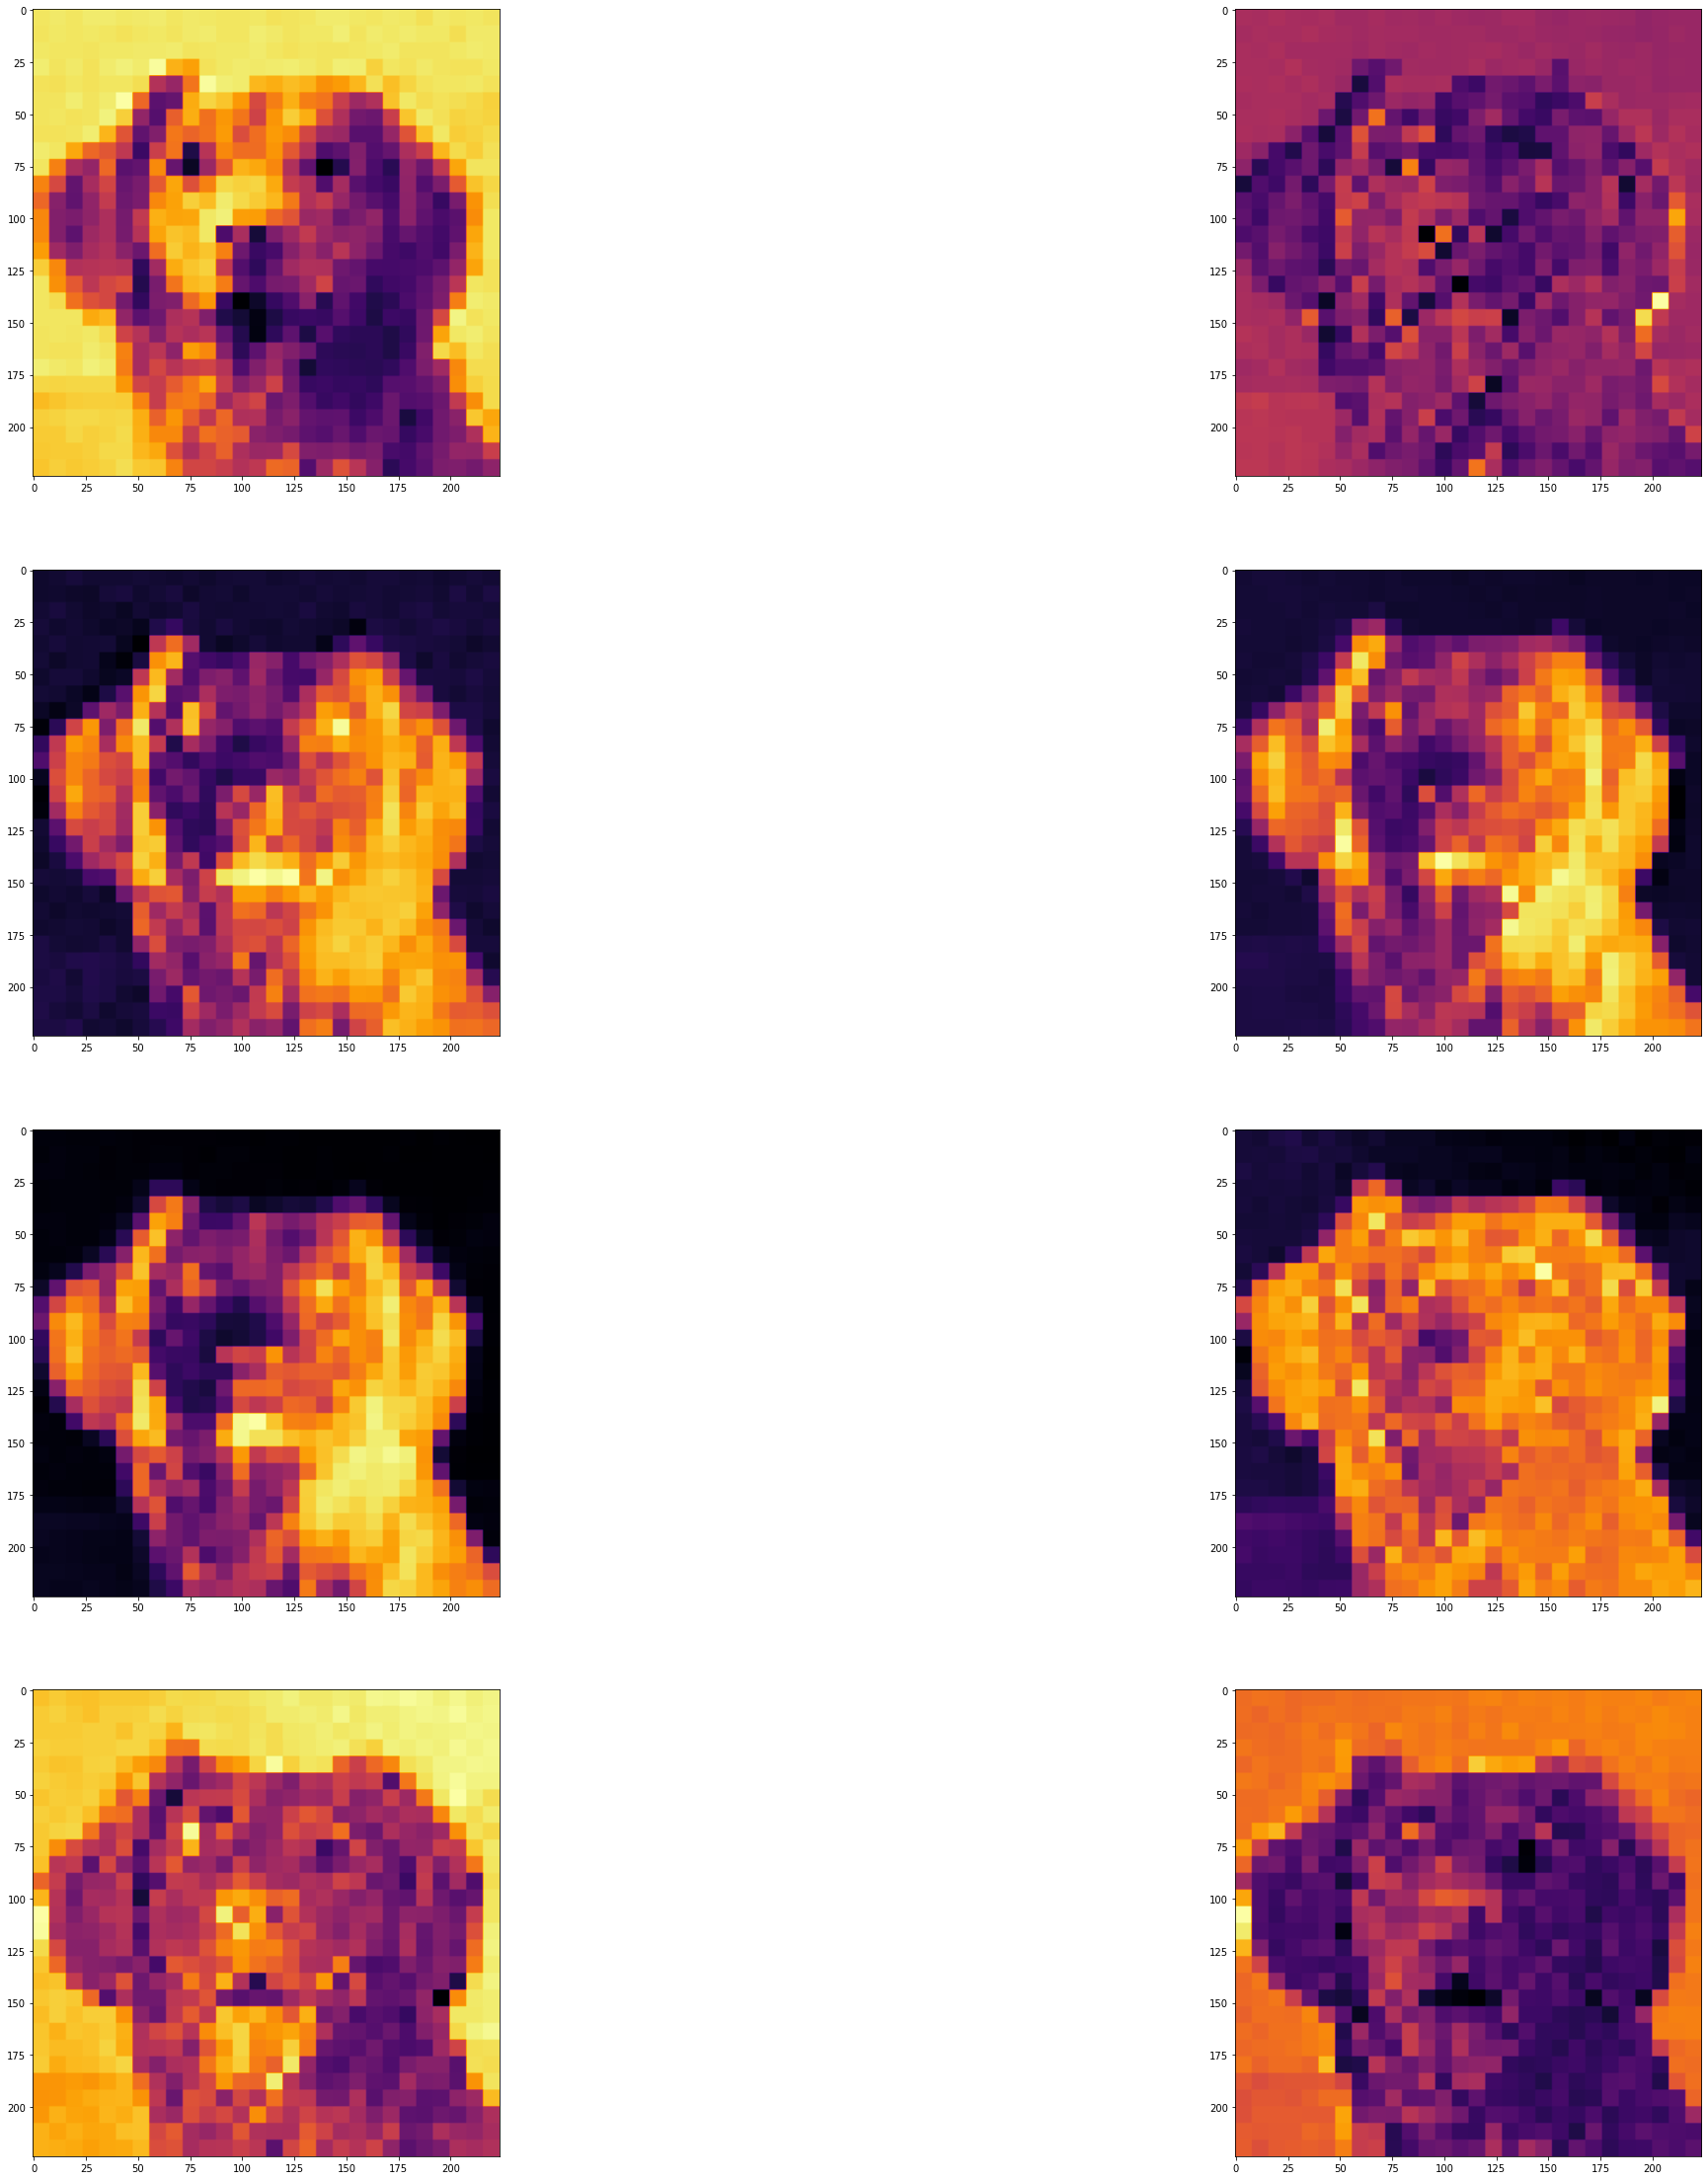

In [32]:
pred, attn = predict('dog.jpg', model=new_model, transform=transform)
print(pred, attn.shape)
plot_attn(attn, patch_size=patch_size)

cat torch.Size([1, 6, 8, 785, 785])


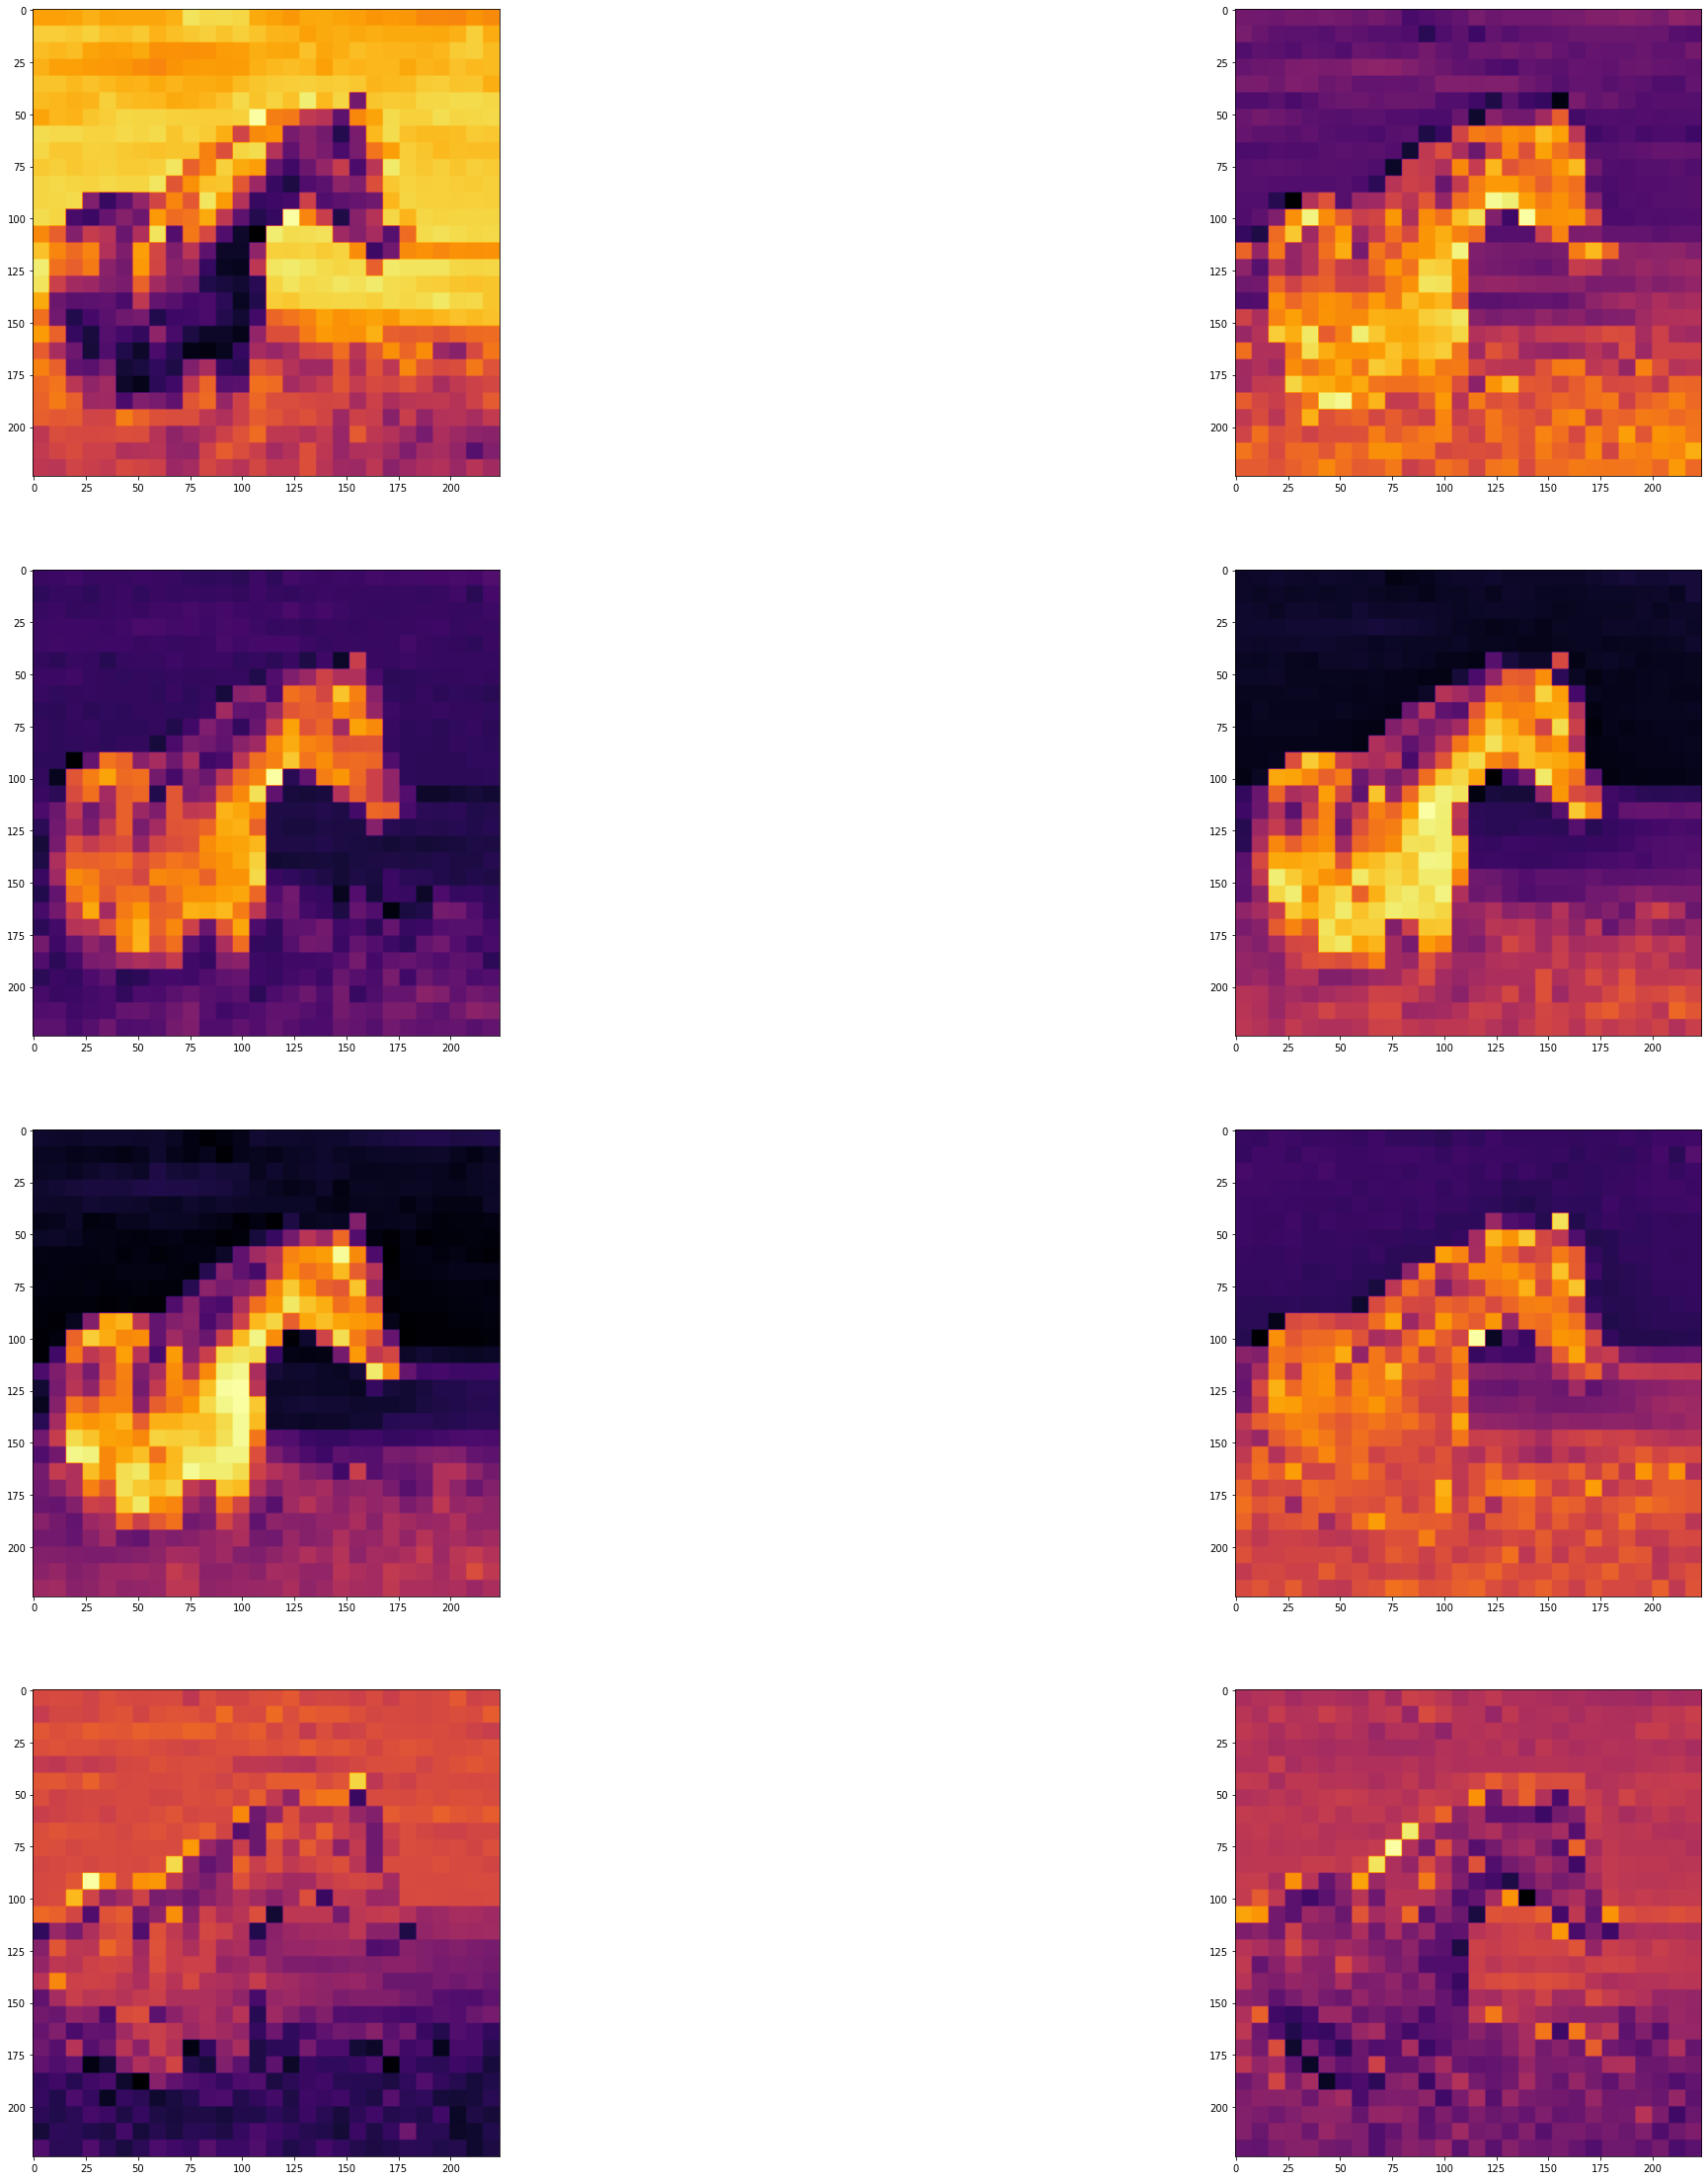

In [33]:
pred, attn = predict('horse.png', model=new_model, transform=transform)
print(pred, attn.shape)
plot_attn(attn, patch_size=patch_size)

automobile torch.Size([1, 6, 8, 785, 785])


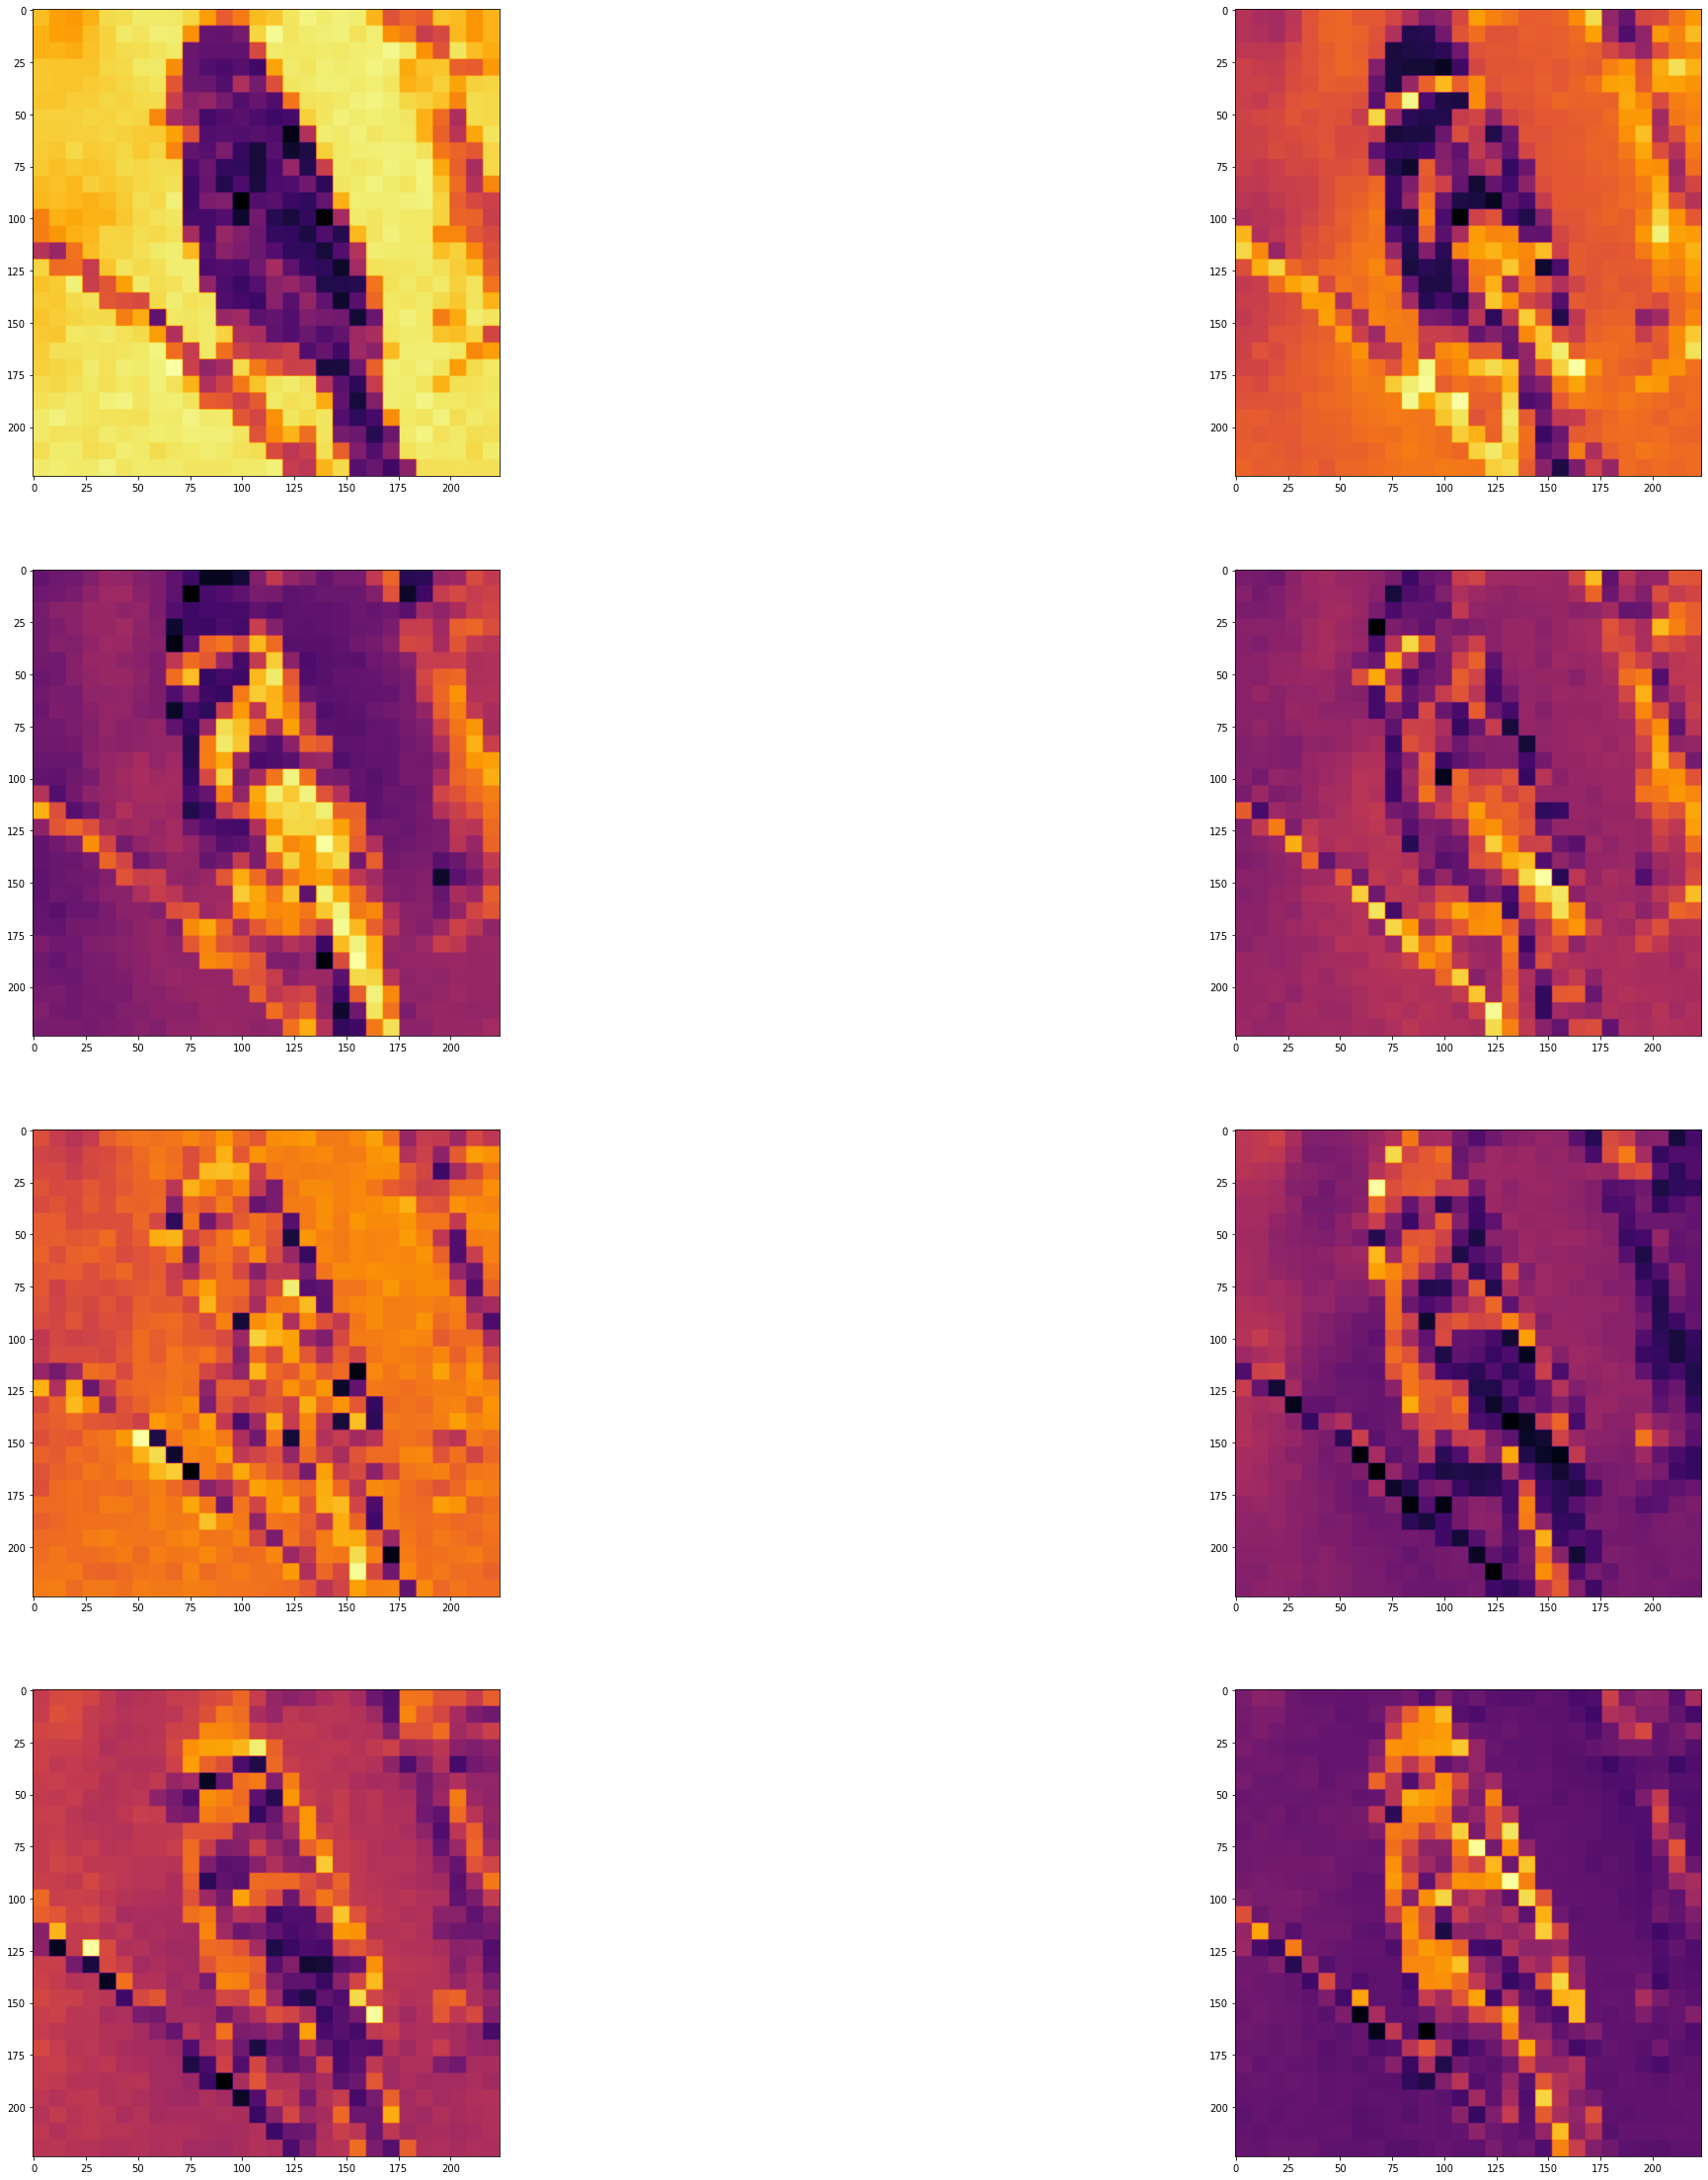

In [34]:
pred, attn = predict('bird.jpg', model=new_model, transform=transform)
print(pred, attn.shape)
plot_attn(attn, patch_size=patch_size)